## **Recommendation System Anime**

Proyek ini bertujuan untuk memberikan rekomendasi anime kepada user, untuk memudahkan mereka dalam memilih tontonan yang sesuai dengan referensi mereka. Hal ini sangat penting untuk kepentingan bisnis, karena dengan menggunakan sistem rekomendasi, user tidak akan kebingungan lagi dalam memilih anime yang ingin dilihat. Hal ini dapat membuat user mendapatkan pengalaman yang baik dari menonton anime itu sendiri.

## **Import Library**

In [1]:
!pip install numpy==1.26.4 pandas matplotlib scikit-surprise

# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from tabulate import tabulate
from nltk.corpus import stopwords
from tqdm.notebook import tqdm

from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import train_test_split, GridSearchCV

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer



> Pada cell ini saya mengimport beberapa library yang akan membantu dalam proses membangun recommendation system. Saya juga menurunkan versi numpy agar kompatibel dengan library surprise.



## **Loading Dataset**

In [2]:
# Download dan ekstrak dataset

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d CooperUnion/anime-recommendations-database
!unzip anime-recommendations-database.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 1.08GB/s]
Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              




> Mendownload dan mengekstrak dataset.



In [3]:
# Membaca dataset

anime_df = pd.read_csv('anime.csv')
rating_df = pd.read_csv('rating.csv')

print("Jumlah Data Anime: ", len(anime_df))
print(anime_df.head())
print("\nJumlah Data Rating: ", len(rating_df))
print(rating_df.head())

Jumlah Data Anime:  12294
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  

Jumlah Data Rating:  7813737
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2  



> Menampilkan jumlah data, 5 data pertama, dan mendefinisikan dataset animec.csv sebagai anime_df, dan rating.csv sebagai rating_df.



## **Exploratory Data Analysis**

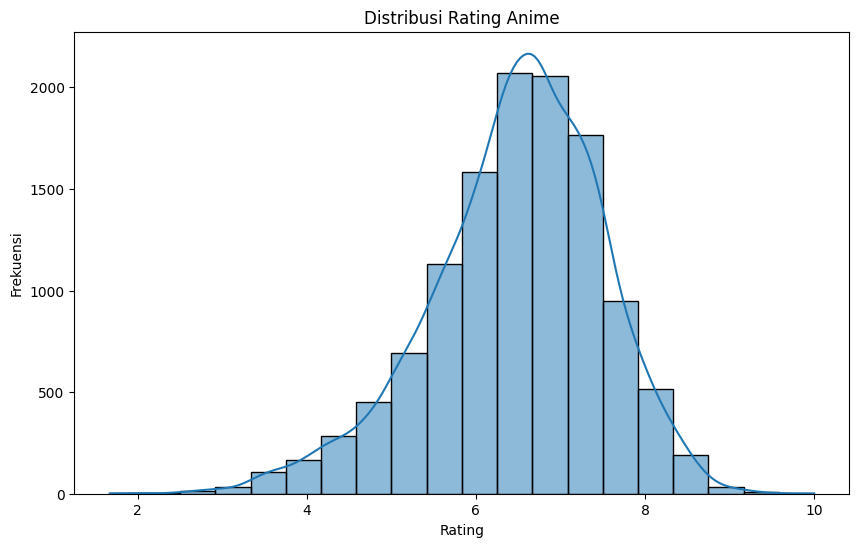

In [4]:
# Menampilkan plot distribusi rating

plt.figure(figsize=(10, 6))
sns.histplot(anime_df['rating'], bins=20, kde=True)
plt.title('Distribusi Rating Anime')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()



> Menampilkan distribusi rating dari dataset. Dari histogram, terlihat bahwa mayoritas anime mendapatkan rating sekitar 6, dengan frekuensi yang menurun pada rating yang lebih tinggi atau lebih rendah. Ini mengindikasikan bahwa rating cenderung berkumpul di sekitar nilai rata-rata, menurunkan proporsi anime dengan rating ekstrem. Area di bawah kurva menunjukkan frekuensi rating, sedangkan garis di atas histogram adalah kurva distribusi yang menunjukkan bagaimana rating tersebar.


<ipython-input-5-848648621>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.index, y=top_genres.values, palette='magma')


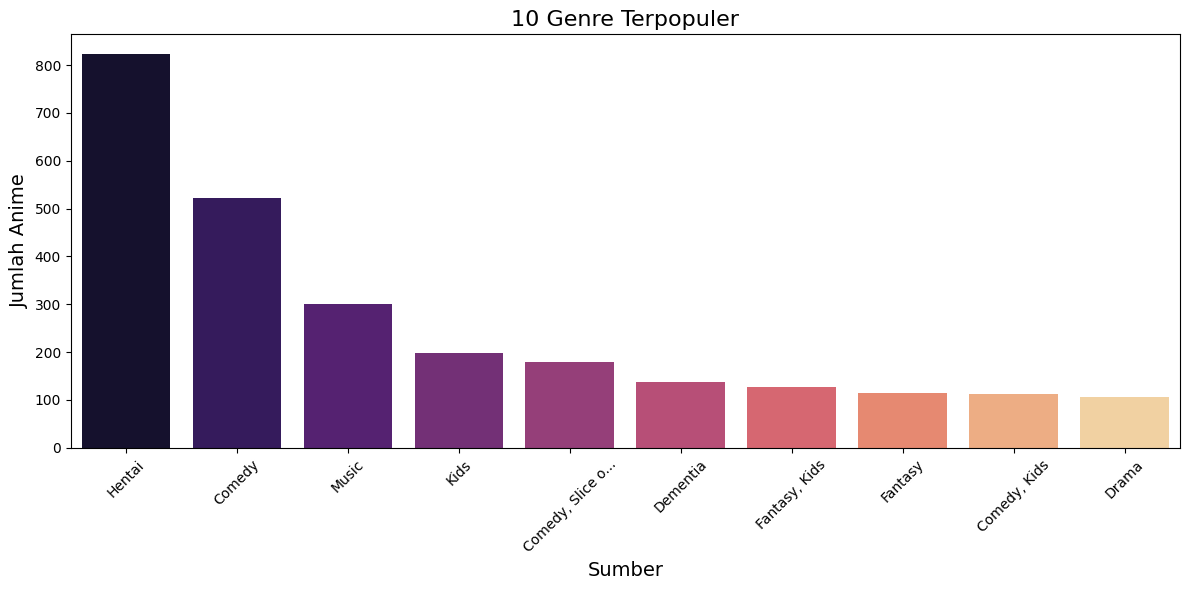

In [5]:
# Menampilkan plot distribusi dari fitur genre

# Menghitung jumlah genre
source_counts = anime_df['genre'].value_counts()

# Memilih 10 genre teratas
top_genres = source_counts.nlargest(10)

# Memperpendek label genre jika panjang
top_genres.index = [genre if len(genre) < 15 else genre[:15] + '...' for genre in top_genres.index]

# Visualisasi distribusi source
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genres.index, y=top_genres.values, palette='magma')
plt.title('10 Genre Terpopuler', fontsize=16)
plt.xlabel('Sumber', fontsize=14)
plt.ylabel('Jumlah Anime', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



> Pada visualisasi distribusi tersebut menunjukkan top 10 jumlah anime berdasarkan genre terpopuler. Terlihat bahwa anime dengan genre Hentai menjadi anime yang paling banyak di dataset ini, disusul dengan genre lainnya, seperti Comedy, Music, Kids dan seterusnya. Hal ini mencermikan bahwa dalam dataset ini mengandung anime dari berbagai genre.

<ipython-input-6-1455959631>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='rating', data=top_anime, palette='magma')


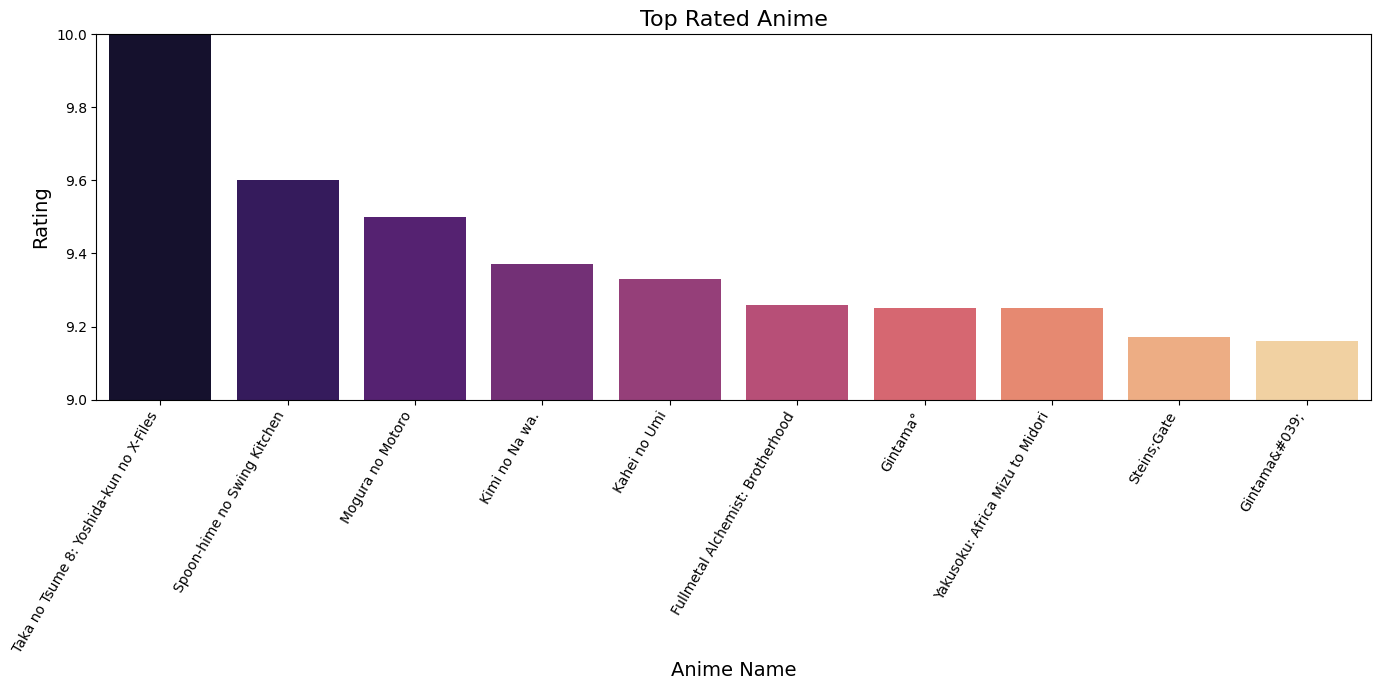

In [6]:
# Menampilkan plot distribusi dari 10 anime dengan rating terbanyak

# Mengambil 10 anime dengan rating tertinggi
top_anime = anime_df.nlargest(10, 'rating')

# Membuat bar chart untuk rating anime berdasarkan nama
plt.figure(figsize=(14, 7))
sns.barplot(x='name', y='rating', data=top_anime, palette='magma')
plt.title('Top Rated Anime', fontsize=16)
plt.xlabel('Anime Name', fontsize=14)
plt.ylabel('Rating', fontsize=14)
plt.xticks(rotation=60, ha='right')
plt.ylim(9, 10)
plt.tight_layout()
plt.show()



> Pada visualisasi ini menampilkan distribusi top 10 anime dengan rating paling tinggi. Terlihat bahwa anime dengan judul "Taka no Tsume 8: Yoshida-kun no X-Files" memiliki rating yang sempurna yaitu 10 dari skala 1-10. Dengan melakukan visualisasi anime apa yang memiliki rating tertinggi dapat memberikan pandangan tentang sistem rekomendasi berdasarkan referensi user.



## **Data Preparation**

In [7]:
# Melihat informasi tentang dataset dari anime_df
print("Info dataset")
print(anime_df.info())
print("\nJumlah value missing")
print(anime_df.isnull().sum())
print("\nJumlah data duplikat")
print(anime_df.duplicated().sum())

Info dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB
None

Jumlah value missing
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Jumlah data duplikat
0


In [8]:
# Melihat informasi tentang dataset dari rating_df
print("Info dataset")
print(rating_df.info())
print("\nJumlah value missing")
print(rating_df.isnull().sum())
print("\nJumlah data duplikat")
print(rating_df.duplicated().sum())

Info dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB
None

Jumlah value missing
user_id     0
anime_id    0
rating      0
dtype: int64

Jumlah data duplikat
1




> Melihat informasi dataset seperti tipe data, value yang hilang, dan data duplikat. Proses ini dapat memudahkan cleaning seperti apa yang bisa digunakan.



In [9]:
# Drop variable yang tidak relevan untuk sistem rekomendasi
# Daftar kolom yang ingin dihapus
kolom_yang_dihapus = [
    'type',
    'episodes'
]

anime_droped = anime_df.drop(columns=kolom_yang_dihapus)

# Tampilkan DataFrame yang telah dibersihkan
print(anime_droped.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   rating    12064 non-null  float64
 4   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 480.4+ KB
None




> Menghapus variable yang tidak relevan untuk digunakan modeling. Disini kita menghapus type dan episodes, yang tidak akan akan berguna untuk model rekomendasi yang kita gunakan.



In [10]:
# Imputasi data missing menggunakan .dropna()

print("Jumlah value missing sebelum imputasi")
print(anime_df.isnull().sum())

anime_clean = anime_droped.dropna()

print("\nJumlah value missing setelah imputasi")
print(anime_clean.isnull().sum())

total_data_after_drop = anime_clean.shape[0]
print(f"\nTotal data setelah imputasi dropna: {total_data_after_drop}")

Jumlah value missing sebelum imputasi
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Jumlah value missing setelah imputasi
anime_id    0
name        0
genre       0
rating      0
members     0
dtype: int64

Total data setelah imputasi dropna: 12017




> Imputasi value yang hilang dengan metode drop, karena efektif dan tidak akan merusak hasil akhir recommendation system.



In [11]:
# Menghapus value duplikat pada rating.csv
print("Jumlah data duplikat sebelum dihapus")
print(rating_df.duplicated().sum())

rating_clean = rating_df.drop_duplicates()

total_data_after_drop_duplicates = rating_clean.shape[0]
print(f"\nTotal data setelah drop duplicates: {total_data_after_drop_duplicates}")

Jumlah data duplikat sebelum dihapus
1

Total data setelah drop duplicates: 7813736




> Menghapus data duplikat dengan metode drop pada rating.csv untuk menjaga kualitas dataset.



In [12]:
# Menampilkan beberapa data teratas

print("Data teratas dari anime.csv setelah data preparation")
print(anime_clean.head())
print("\nData teratas rating.csv setelah data preparation")
print(rating_clean.head())

Data teratas dari anime.csv setelah data preparation
   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre  rating  members  
0               Drama, Romance, School, Supernatural    9.37   200630  
1  Action, Adventure, Drama, Fantasy, Magic, Mili...    9.26   793665  
2  Action, Comedy, Historical, Parody, Samurai, S...    9.25   114262  
3                                   Sci-Fi, Thriller    9.17   673572  
4  Action, Comedy, Historical, Parody, Samurai, S...    9.16   151266  

Data teratas rating.csv setelah data preparation
   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241     



> Mengecek data teratas setelah data preparation untuk memudahkan langkah selanjutnya.



## **Content-Based Filtering**

In [13]:
# Filter menghapus beberapa anime yang memiliki sedikit member untuk efisiensi

print(f"Jumlah anime sebelum difilter: {len(anime_clean)}")

# Hanya mengambil anime yang memiliki lebih dari 1000 members.
minimal_members = 1000
anime_filtered = anime_clean[anime_clean['members'] > minimal_members].copy()

# Reset index agar berurutan dari 0
anime_filtered.reset_index(drop=True, inplace=True)

print(f"Jumlah anime setelah difilter: {len(anime_filtered)}")

Jumlah anime sebelum difilter: 12017
Jumlah anime setelah difilter: 6789




> Mengambil anime dengan syarat minimal 1000 members dapat meningkatkan efisiensi pemrosesan, karena mengurangi jumlah anime yang akan dibuat rekomendasi.



In [14]:
# Normalisasi fitur genre

def normalize_genres(genre_string):
    if not isinstance(genre_string, str):
        return ""

    # Convert ke lowercase, dan menghapus koma
    genre_list = genre_string.lower().split(',')

    # Menghapus spasi pada awal dan akhir genre
    # Contoh '  Action ' menjadi 'Action'
    cleaned_genres = [genre.strip() for genre in genre_list]

    # Gabungkan genre yang sudah bersih menjadi satu string
    return " ".join(cleaned_genres)

# Membuat kolom genre_normalized pada dataframe
anime_filtered['genre_normalized'] = anime_filtered['genre'].apply(normalize_genres)

# Menampilkan 5 data teratas setelah normalisasi
print("Normalisasi berhasil, genre_normalized ditambahkan")
print("Result setelah normalisasi:")
print(anime_filtered[['name', 'genre', 'genre_normalized']].head())

Normalisasi berhasil, genre_normalized ditambahkan
Result setelah normalisasi:
                               name  \
0                    Kimi no Na wa.   
1  Fullmetal Alchemist: Brotherhood   
2                          Gintama°   
3                       Steins;Gate   
4                     Gintama&#039;   

                                               genre  \
0               Drama, Romance, School, Supernatural   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...   
2  Action, Comedy, Historical, Parody, Samurai, S...   
3                                   Sci-Fi, Thriller   
4  Action, Comedy, Historical, Parody, Samurai, S...   

                                    genre_normalized  
0                  drama romance school supernatural  
1  action adventure drama fantasy magic military ...  
2  action comedy historical parody samurai sci-fi...  
3                                    sci-fi thriller  
4  action comedy historical parody samurai sci-fi...  




> Melakukan normalisasi pada variable genre untuk memudahkan pemrosesan TF-IDF Vectorizer. Berfungsi untuk membersihkan dan menyatukan genre anime dalam satu string yang rapi. Normalisasi genre ini penting untuk memastikan representasi yang konsisten dan terstruktur, yang akan membantu dalam pemrosesan selanjutnya.

In [15]:
# Vectorisasi TF-IDF

print("Memulai TF-IDF Vectorization...")

# Inisialisasi TfidfVectorizer dengan parameter max_features
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)

# Proses fit_transform untuk mengubah teks genre menjadi matriks angka (TF-IDF)
tfidf_matrix = vectorizer.fit_transform(anime_filtered['genre_normalized'])

print("TF-IDF vectorization sudah selesai.")
print("Shape dari TF-IDF matrix:", tfidf_matrix.shape)

Memulai TF-IDF Vectorization...
TF-IDF vectorization sudah selesai.
Shape dari TF-IDF matrix: (6789, 46)




> Melakukan vectorisasi teks menggunakan TF-IDF untuk mengubah deskripsi genre anime menjadi matriks angka yang dapat diproses oleh model machine learning. Matriks TF-IDF yang dihasilkan akan digunakan sebagai fitur input untuk model machine learning selanjutnya



In [16]:
# Menghitung Cosine Similarity

print("Calculating cosine similarity...")

cosine_sim = cosine_similarity(tfidf_matrix)

print("Cosine similarity matrix created successfully.")
print("Shape of the similarity matrix:", cosine_sim.shape)

Calculating cosine similarity...
Cosine similarity matrix created successfully.
Shape of the similarity matrix: (6789, 6789)




> Menghitung kemiripan genre dengan matriks yang sudah dibuat oleh TF-IDF Vectorizer. Dengan memiliki matriks kesamaan cosinus, sistem rekomendasi dapat menerapkan strategi rekomendasi berbasis konten yang lebih canggih untuk memberikan rekomendasi yang relevan bagi pengguna.



In [17]:
# Membuat model rekomendasi

# Membuat jalur dari judul ke indeks
indices = pd.Series(anime_filtered.index, index=anime_filtered['name']).drop_duplicates()

# Membuat fungsi rekomendasi
def get_recommendations(title, cosine_sim_matrix=cosine_sim, index_map=indices):
    matching_title = None
    for original_name in index_map.index:
        if title.lower() == original_name.lower():
            matching_title = original_name
            break

    if matching_title is None:
        # Kembalikan None untuk kedua nilai jika tidak ditemukan
        return f"Anime dengan judul '{title}' tidak ditemukan di dataset. (┬┬﹏┬┬)", None

    try:
        idx = index_map[matching_title]
    except KeyError:
        return f"Anime dengan judul '{matching_title}' tidak ditemukan di dataset. (┬┬﹏┬┬)", None

    if isinstance(idx, pd.Series):
        idx = idx.iloc[0]

    sim_scores = sorted(list(enumerate(cosine_sim_matrix[idx])), key=lambda x: x[1], reverse=True)

    # Filtering
    recommendations_indices = []
    recommended_titles_seen = set()
    base_name = matching_title.lower().split(':')[0].strip()

    for anime_idx, score in sim_scores:
        if len(recommendations_indices) >= 10:
            break
        recommended_title = anime_filtered['name'].iloc[anime_idx]
        if anime_idx == idx or recommended_title in recommended_titles_seen or base_name in recommended_title.lower():
            continue

        recommendations_indices.append(anime_idx)
        recommended_titles_seen.add(recommended_title)

    if not recommendations_indices:
        return "Maaf, kami tidak dapat menemukan anime dengan genre yang mirip. (┬┬﹏┬┬)", matching_title

    return anime_filtered.iloc[recommendations_indices], matching_title



> Membuat fungsi rekomendasi dengan beberapa fungsi. Fungsi utamanya adalah mengubah inputan supaya tidak *case sensitive*, membuat filter agar anime yang diinputkan oleh user tidak tampil di rekomendasi, dan tidak menghasilkan anime dengan nama franchise yang sama. Hal ini efektif untuk menghasilkan output terbaik



In [18]:
# Penggunaan sistem rekomendasi

# Input dari user
anime_title_input = input("Masukkan judul anime yang kamu suka (Judul menurut versi jepang yah (●'◡'●)): ")

# Panggil fungsi untuk mendapatkan dua nilai, rekomendasi dan judul yang cocok
recommendations, matched_title = get_recommendations(anime_title_input)

print("\n" + "="*80)

# Cek apakah rekomendasi berhasil didapatkan
if isinstance(recommendations, pd.DataFrame):
    try:
        # Gunakan 'matched_title' untuk mencari
        input_anime_details = anime_filtered[anime_filtered['name'] == matched_title].head(1)

        # Siapkan DataFrame untuk ditampilkan
        input_display_df = input_anime_details[['name', 'genre', 'rating']].rename(columns={
            'name': 'Judul anime',
            'genre': 'Genre',
            'rating': 'Rating'
        })

        print("--- Detail anime yang kamu input ---")
        print(tabulate(input_display_df, headers='keys', tablefmt='pretty', showindex=False))
        print("\n" + "-"*80 + "\n")
    except Exception as e:
        print(f"Tidak dapat menampilkan anime. error: {e}")

    # Menampilkan hasil rekomendasi
    print(f"--- Top 10 anime yang mirip dengan '{matched_title}' ---")

    recommendations_display_df = recommendations[['name', 'genre', 'rating']].rename(columns={
        'name': 'Judul Rekomendasi',
        'genre': 'Genre',
        'rating': 'Rating'
    })

    print(tabulate(recommendations_display_df, headers='keys', tablefmt='pretty', showindex=False))

# Jika anime tidak ditemukan, cetak pesan error
else:
    print(recommendations)

print("="*80)

Masukkan judul anime yang kamu suka (Judul menurut versi jepang yah (●'◡'●)): Shingeki no kyojin

--- Detail anime yang kamu input ---
+--------------------+----------------------------------------------+--------+
|    Judul anime     |                    Genre                     | Rating |
+--------------------+----------------------------------------------+--------+
| Shingeki no Kyojin | Action, Drama, Fantasy, Shounen, Super Power |  8.54  |
+--------------------+----------------------------------------------+--------+

--------------------------------------------------------------------------------

--- Top 10 anime yang mirip dengan 'Shingeki no Kyojin' ---
+----------------------------------------------------------------------------------------+-----------------------------------------------------------------+--------+
|                                   Judul Rekomendasi                                    |                              Genre                              | Rati



> Menghasilkan output berupa rekomendasi dari input user. Output akan menghasilkan anime dengan genre yang mirip-mirip dengan inputan dari user.



## **Collaborative Filtering**

In [19]:
# Mengecualikan value -1 pada dataset

ratings_final = rating_clean[rating_clean['rating'] != -1].copy()
print(f"Jumlah data setelah memfilter value -1: {len(ratings_final)}")
print("Data setelah memfilter value -1:")
print(ratings_final.head())

Jumlah data setelah memfilter value -1: 6337240
Data setelah memfilter value -1:
     user_id  anime_id  rating
47         1      8074      10
81         1     11617      10
83         1     11757      10
101        1     15451      10
153        2     11771      10




> Mengecualikan data dengan value -1 pada kolom rating, karena tidak relevan untuk proses collaborative filtering (-1 dianggap sebagai user yang tidak memberikan rating walaupun sudah menonton animenya)



In [20]:
# Mengambil sample data untuk efisiensi pemrosesan

print(f"Jumlah rating bersih sebelum sampling: {len(ratings_final)}")
df_subset = ratings_final.sample(n=500000, random_state=42)
print(f"Menggunakan {len(df_subset)} rating untuk melatih model setelah sampling.")

Jumlah rating bersih sebelum sampling: 6337240
Menggunakan 500000 rating untuk melatih model setelah sampling.




> Mengambil 500.000 sampel dari dataset rating untuk meningkatkan efisiensi pemrosesan model.



In [21]:
# Memuat Data ke dalam Format Library Surprise
print("\nMengubah data ke format 'Surprise'...")
# Definisikan 'Reader' dengan skala rating dari 1 hingga 10.
reader = Reader(rating_scale=(1, 10))
# Muat data dari DataFrame subset
data = Dataset.load_from_df(df_subset[['user_id', 'anime_id', 'rating']], reader)
print("Data berhasil dimuat ke format Surprise.")


Mengubah data ke format 'Surprise'...
Data berhasil dimuat ke format Surprise.




> Mengubah data menjadi format surprise yang akan digunakan untuk pemodelan sistem rekomendasi. Mendefinisikan rating sebagai 1-10. Format ini juga memudahkan evaluasi model, seperti melakukan cross-validation dan menghitung metrik evaluasi yang diperlukan.



In [22]:
# Split data
print("Membagi data menjadi training set dan testing set...")
trainset, testset = train_test_split(data, test_size=0.20, random_state=42)

Membagi data menjadi training set dan testing set...




> Melakukan splitting data dengan 20% data dialokasikan untuk pengujian.



In [23]:
# Training model

print("Melatih model pada training set...")
algo = SVD(n_factors=100, n_epochs=20, random_state=42)
algo.fit(trainset)

# Melakukan prediksi pada testing
print("Melakukan prediksi pada testing set...")
predictions = algo.test(testset)

# Menghitung skor prediksi dari RMSE dan MAE
print("\n--- Hasil Evaluasi Model ---")
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

print(f"RMSE (Root Mean Squared Error): {rmse}")
print(f"MAE (Mean Absolute Error):      {mae}")

Melatih model pada training set...
Melakukan prediksi pada testing set...

--- Hasil Evaluasi Model ---
RMSE: 1.3122
MAE:  1.0078
RMSE (Root Mean Squared Error): 1.3121737231759676
MAE (Mean Absolute Error):      1.0077963533800085




> SVD akan melakukan pelatihan dengan parameter sederhana. Setelah pelatihan akan menghasilkan skor evaluasi yang bisa digunakan untuk patokan melakukan Hyperparameter atau tidak.


In [24]:
# Hyperparameter tuning menggunakan GridSearchCV

# Menentukan parameter
param_grid = {
    "n_factors": [50, 100, 150],
    "n_epochs": [20, 30],
    "lr_all": [0.005, 0.01],
    "reg_all": [0.02, 0.1, 0.4]
}

# Inisialisasi GridSearchCV
gs = GridSearchCV(
    SVD,
    param_grid,
    measures=["rmse", "mae"],
    cv=3,
    joblib_verbose=3
)

# Jalankan pencarian pada data
print("Memulai GridSearchCV untuk mencari parameter terbaik...")
gs.fit(data)

# Tampilkan hasil terbaik
print("\n--- Hasil GridSearchCV ---")

# Skor RMSE terbaik yang ditemukan
print(f"Skor RMSE terbaik: {gs.best_score['rmse']:.4f}")

# Kombinasi parameter yang menghasilkan skor terbaik
print("Parameter terbaik:")
print(gs.best_params['rmse'])

Memulai GridSearchCV untuk mencari parameter terbaik...


[Parallel(n_jobs=1)]: Done  31 tasks      | elapsed:  4.7min



--- Hasil GridSearchCV ---
Skor RMSE terbaik: 1.2855
Parameter terbaik:
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 20.4min finished




> Menggunakan hyperparameter tuning untuk mendapatkan parameter terbaik untuk training model SVD menggunakan GridSearchCV. Parameter yang akan diuji didefinisikan dalam dictionary, termasuk jumlah faktor, jumlah epoch, learning rate, dan regularisasi. Hyperparameter tuning berguna sekali untuk mendapatkan parameter terbaik agar model mendapatkan hasil dengan maksimal.



In [25]:
# Melatih model final menggunakan parameter terbaik
print("Melatih model final menggunakan parameter terbaik dari GridSearchCV...")

# Ambil dictionary berisi parameter terbaik
best_params = gs.best_params['rmse']

# Inisialisasi model SVD baru dengan parameter terbaik
algo_final = SVD(**best_params, random_state=42, verbose=True)

# Latih model pada keseluruhan data
print("Melatih model final pada data yang telah disiapkan...")
full_trainset = data.build_full_trainset()
algo_final.fit(full_trainset)

print("Model final berhasil dilatih!")

Melatih model final menggunakan parameter terbaik dari GridSearchCV...
Melatih model final pada data yang telah disiapkan...
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Model final berhasil dilatih!




> Training model menggunakan algoritma SVD dengan menggunakan parameter terbaik dari Hyperparameter tuning GridSearchCV.



In [26]:
# Menampilkan skor dari training dan tuning
predictions_on_train_data = algo_final.test(full_trainset.build_testset())

print("\n--- Skor Performa pada Data Training ---")
training_rmse = accuracy.rmse(predictions, verbose=False)
training_mae = accuracy.mae(predictions, verbose=False)

print(f"Training RMSE: {training_rmse:.4f}")
print(f"Training MAE:  {training_mae:.4f}")

print("\nSebagai perbandingan:")

try:
    print(f"Testing RMSE (dari GridSearchCV): {gs.best_score['rmse']:.4f}")
    print(f"Testing MAE (dari GridSearchCV): {gs.best_score['mae']:.4f}")
except NameError:
    print("Objek GridSearchCV 'gs' tidak ditemukan untuk perbandingan.")


--- Skor Performa pada Data Training ---
Training RMSE: 1.3122
Training MAE:  1.0078

Sebagai perbandingan:
Testing RMSE (dari GridSearchCV): 1.2855
Testing MAE (dari GridSearchCV): 0.9849




> Evaluasi dan membandingkan model dengan dan tanpa Hyperparameter. Terlihat hasil yang lumayan signifikan, yang sebelumnya training RMSE menghasilkan nilai 1.3122, setelah melakukan Hyperparameter tuning menggunakan GridSearchCV menghasilkan nilai 1.2849. Nilai RMSE yang lebih rendah menunjukkan performa yang lebih baik.





In [27]:
# Membuat fungsi rekomendasi

def get_collaborative_recommendations(user_id, model, n=10):
    # Menyiapkan daftar anime
    all_anime_ids = anime_df['anime_id'].unique()
    watched_anime_ids = rating_clean[rating_clean['user_id'] == user_id]['anime_id'].unique()
    unwatched_anime_ids = np.setdiff1d(all_anime_ids, watched_anime_ids)

    # Prediksi rating untuk semua anime yang belum ditonton
    predictions = [model.predict(user_id, anime_id) for anime_id in unwatched_anime_ids]

    # Urutkan prediksi berdasarkan estimasi rating dari yang tertinggi
    predictions.sort(key=lambda x: x.est, reverse=True)

    # Prediksi teratas
    top_n_predictions = predictions[:n]

    # Menyiapkan hasil akhir untuk ditampilkan
    recommended_anime_ids = [pred.iid for pred in top_n_predictions]
    recommendations_df = anime_df[anime_df['anime_id'].isin(recommended_anime_ids)].copy()

    # Tambahkan kolom prediksi rating untuk memberikan konteks
    predicted_ratings = {pred.iid: pred.est for pred in top_n_predictions}
    recommendations_df['predicted_rating'] = recommendations_df['anime_id'].map(predicted_ratings)

    # Urutkan sekali lagi untuk memastikan urutan output sesuai prediksi rating
    recommendations_df = recommendations_df.sort_values(by='predicted_rating', ascending=False)

    return recommendations_df[['name', 'genre', 'rating', 'predicted_rating']]



> Membuat fungsi rekomendasi dari daftar anime, kemudian mengambil judul anime yang belum pernah ditonton untuk hasil dari rekomendasinya. Menampilkan top 20 anime rekomendasi dan mengurutkannya dengan rekomendasi paling tinggi hingga rendah.



In [28]:
# Penggunaan sistem rekomendasi

# Input dari user
user_id_input_str = input("Masukkan User ID yang ingin Anda lihat rekomendasinya: ")

try:
    target_user_id = int(user_id_input_str)
    print(f"\nMenghasilkan rekomendasi untuk User ID: {target_user_id}...")
    user_recommendations = get_collaborative_recommendations(target_user_id, model=algo_final, n=20) # Mengeluarkan rekomendasi sebanyak 20

    # Tampilkan Hasil Akhir
    print("\n" + "="*90)

    if not user_recommendations.empty:
        print(f"Top 20 Rekomendasi Anime untuk User ID {target_user_id}:")
        print(tabulate(user_recommendations, headers='keys', tablefmt='pretty', showindex=False))
    else:
        print(f"Tidak dapat menghasilkan rekomendasi untuk User ID {target_user_id}.")

    print("="*90)

except ValueError:
    print("\n[ERROR] Input tidak valid. Harap masukkan User ID dalam bentuk angka.")
except Exception as e:
    print(f"\n[ERROR] Terjadi sebuah kesalahan: {e}")

Masukkan User ID yang ingin Anda lihat rekomendasinya: 512

Menghasilkan rekomendasi untuk User ID: 512...

Top 20 Rekomendasi Anime untuk User ID 512:
+-----------------------------------------------------------+------------------------------------------------------------------------------+--------+-------------------+
|                           name                            |                                    genre                                     | rating | predicted_rating  |
+-----------------------------------------------------------+------------------------------------------------------------------------------+--------+-------------------+
|                   Ginga Eiyuu Densetsu                    |                        Drama, Military, Sci-Fi, Space                        |  9.11  |       10.0        |
|                         Gintama°                          |         Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen         |  9.25  | 9.954993962998985 



> Menampilkan hasil rekomendasi 20 anime berdasarkan rekomendasi histori user, dan menambahkan fungsi input dari user untuk memudahkan melihat rekomendasi setiap user. Membuat fungsi agar input hanya dapat diisi dengan angka, dan jika selain angka akan error.



### **EVALUASI MODEL**

#### Content-Based Filtering

In [29]:
# Evaluasi Model Content-Based Filtering

# Persiapan Data dan Pemetaan
# Tentukan ambang batas rating dan K
RATING_THRESHOLD = 8.0
K = 10

# Buat pemetaan dari anime_id ke indeks internal matriks
id_map = pd.Series(anime_filtered.index, index=anime_filtered['anime_id'])

# Ambil sampel pengguna aktif untuk dievaluasi
user_activity = rating_clean['user_id'].value_counts()
active_users = user_activity[user_activity > 50].index.tolist()
test_users = random.sample(active_users, 500) if len(active_users) > 500 else active_users

print(f"Memulai evaluasi pada {len(test_users)} pengguna...")

def get_top_k_similar_by_index(source_idx, k=10):
    """Fungsi ringan untuk mendapatkan top-k rekomendasi berdasarkan indeks."""
    # Mengambil skore matriks cosine_sim
    sim_scores = list(enumerate(cosine_sim[source_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil indeks dari K anime teratas
    top_indices = [i[0] for i in sim_scores[1:k+1]]
    return top_indices

# Evaluasi
precisions, recalls, f1_scores = [], [], []

for user_id in tqdm(test_users, desc="Mengevaluasi Pengguna"):

    # Dapatkan ID dari semua anime yang disukai pengguna
    liked_anime_ids = rating_clean[(rating_clean['user_id'] == user_id) & (rating_clean['rating'] >= RATING_THRESHOLD)]['anime_id']
    # Ubah ID anime menjadi indeks internal matriks
    liked_indices = [id_map.get(anime_id) for anime_id in liked_anime_ids if anime_id in id_map]
    liked_indices = [idx for idx in liked_indices if idx is not None]

    if len(liked_indices) < 2:
        continue

    # Ambil satu sebagai umpan (source), sisanya sebagai jawaban (ground truth)
    source_idx = random.choice(liked_indices)
    ground_truth_indices = set(liked_indices) - {source_idx}

    # Dapatkan rekomendasi
    recommended_indices = set(get_top_k_similar_by_index(source_idx, k=K))

    # Hitung metrik
    hits = len(recommended_indices.intersection(ground_truth_indices))
    precision = hits / K
    recall = hits / len(ground_truth_indices)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

# Menampilkan hasil akhir
avg_precision = np.mean(precisions) if precisions else 0
avg_recall = np.mean(recalls) if recalls else 0
avg_f1 = np.mean(f1_scores) if f1_scores else 0

print("\n--- Hasil Evaluasi ---")
print(f"Metrik dievaluasi pada {len(precisions)} pengguna dengan K={K}")
print(f"Rata-rata Precision@{K}: {avg_precision:.4f}")
print(f"Rata-rata Recall@{K}:    {avg_recall:.4f}")
print(f"Rata-rata F1-score@{K}:  {avg_f1:.4f}")

Memulai evaluasi pada 500 pengguna...


Mengevaluasi Pengguna:   0%|          | 0/500 [00:00<?, ?it/s]


--- Hasil Evaluasi ---
Metrik dievaluasi pada 481 pengguna dengan K=10
Rata-rata Precision@10: 0.0767
Rata-rata Recall@10:    0.0147
Rata-rata F1-score@10:  0.0198


#### Collaborative Filtering

In [30]:
# Hitung skornya
training_rmse = accuracy.rmse(predictions, verbose=False)
training_mae = accuracy.mae(predictions, verbose=False)

# 2. Siapkan hasil dari GridSearchCV yang sudah disimpan di objek 'gs'
tuned_rmse = gs.best_score['rmse']
tuned_mae = gs.best_score['mae']


# --- Tampilkan Perbandingan ---

print("\n" + "="*55)
print("--- Perbandingan Skor Model Collaborative Filtering ---")
print("="*55)

print("\nSkor dari Model Final (Dilatih pada Semua Data):")
print(f"  - Training RMSE: {training_rmse:.4f}")
print(f"  - Training MAE:  {training_mae:.4f}")

print("\nSkor dari Hasil Hyperparameter Tuning (GridSearchCV):")
print(f"  - Validation RMSE: {tuned_rmse:.4f}")
print(f"  - Validation MAE : {tuned_mae:.4f}")
print("="*55)


--- Perbandingan Skor Model Collaborative Filtering ---

Skor dari Model Final (Dilatih pada Semua Data):
  - Training RMSE: 1.3122
  - Training MAE:  1.0078

Skor dari Hasil Hyperparameter Tuning (GridSearchCV):
  - Validation RMSE: 1.2855
  - Validation MAE : 0.9849
